<a href="https://colab.research.google.com/github/sanghoonsim/EEE511-Artificial-Neural-Computation/blob/main/No_Attention_flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Acquisition

In [1]:
# Download Flickr8k and unzip
!gdown --id 1QtXenCITpdtSfm9rR45_j3WspBSexZqD --output Flickr8k_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1QtXenCITpdtSfm9rR45_j3WspBSexZqD
To: /content/Flickr8k_dataset.zip
100% 1.12G/1.12G [00:12<00:00, 90.5MB/s]


In [2]:
%%capture
!unzip Flickr8k_dataset.zip

In [3]:
# Install library to calculate BLEU Score
!pip install torchtext==0.6.0

     |████████████████████████████████| 64 kB 1.7 MB/s 
     |████████████████████████████████| 1.2 MB 8.2 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0


## Data Preprocessing

In [4]:
!rm ./Flickr8k_dataset/Images/.DS_Store

In [5]:
#!rm -rf ./resized_test/
#!rm -rf ./resized_train/
#!rm -rf ./resized_val/

In [6]:
# Resize all the images in the dataset
import os
from PIL import Image

image_dir = "./Flickr8k_dataset/Images" # Path to original image
train_image_dir = "./resized_train/images" # Path to resized image(Training)
val_image_dir = "./resized_val/images" # Path to resized image(Validation)
test_image_dir = "./resized_test/images" # Path to resized image(Testing)
size = [256, 256] # size of resized image


def resize_image(image, size):
    # Image,ANTIALIAS: to avoid defection when high resolution image is resized into low resolution  
    return image.resize(size, Image.ANTIALIAS) 

# Create directories to split dataset(train, validation, and test)
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
    os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)

images = sorted(os.listdir(image_dir)) # Sort files by the name of the images
num_images = len(images) # The number of images ===> 8091
num_train_images = 6000 # 6000 for Learning data
num_val_images = 1000 # 1000 for validation and the rest(1000) is test
print("The number of images", num_images)

The number of images 8091


In [7]:
for i, image in enumerate(images): # Split images into the three categories
    # print(i, image) : 0 1000268201_693b08cb0e.jpg
    if (i + 1) <= num_train_images: # if train set
        output_dir = train_image_dir
    elif (i + 1) <= num_train_images + num_val_images: # if validation set
        output_dir = val_image_dir
    else: # If test set
        output_dir = test_image_dir
    with open(os.path.join(image_dir, image), 'rb+') as f:
        with Image.open(f) as img:
            img = resize_image(img, size) # resize image
            img.save(os.path.join(output_dir, image), img.format) # and save to split folder
    if (i + 1) % 500 == 0: # print progress in every 500-th turn
        print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")

[500/8091] Resized the images and saved into './resized_train/images'
[1000/8091] Resized the images and saved into './resized_train/images'
[1500/8091] Resized the images and saved into './resized_train/images'
[2000/8091] Resized the images and saved into './resized_train/images'
[2500/8091] Resized the images and saved into './resized_train/images'
[3000/8091] Resized the images and saved into './resized_train/images'
[3500/8091] Resized the images and saved into './resized_train/images'
[4000/8091] Resized the images and saved into './resized_train/images'
[4500/8091] Resized the images and saved into './resized_train/images'
[5000/8091] Resized the images and saved into './resized_train/images'
[5500/8091] Resized the images and saved into './resized_train/images'
[6000/8091] Resized the images and saved into './resized_train/images'
[6500/8091] Resized the images and saved into './resized_val/images'
[7000/8091] Resized the images and saved into './resized_val/images'
[7500/8091]

In [8]:
caption_path = "./Flickr8k_dataset/captions.txt" # Path to captions.txt
with open(caption_path, "r") as f: # Read ./Flickr8k_dataset/captions.txt
    lines = sorted(f.readlines()[1:]) # skpi the 0-th line because it is the headline
    print(lines[40000])

888425986_e4b6c12324.jpg,A boy is upside down in midair near a lake at sunset .



In [9]:
# Build vocabs using captions
import pickle # To store the python object as file
import nltk # For tokenization, typically used for natural language processing
from collections import Counter # To implement count on each word

nltk.download('punkt') # Download tokenizer

caption_path = "./Flickr8k_dataset/captions.txt" # Path to captions.txt
vocab_path = "./vocab.pkl" # Path to vocabulary
word_threshold = 4 # the minumum requirement to appear for each word
train_caption_path = "./resized_train/captions.txt" # Path to captions of resized image(Training)
val_caption_path = "./resized_val/captions.txt" # Path to captions of resized image(Validation)
test_caption_path = "./resized_test/captions.txt" # Path to captions of resized image(Testing)


# Vocabulary Class
# Add general tags in to the dictionary
# Add the words that appears 5 times or more into the dictionary
# Maintains two types of dictionary, word to index, and index to word
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {} # dictionary word(key) : index(value)
        self.idx2word = {} # dictionary index(key) : word(value)
        self.idx = 0 # Start from 0

    def add_word(self, word): # Add word to vocab dictionary
        if not word in self.word2idx: # if not exist in the dictionary
            self.word2idx[word] = self.idx # by word
            self.idx2word[self.idx] = word # by index
            self.idx += 1 # Increase the index by 1

    def __call__(self, word):
        if not word in self.word2idx: # if the word doesn't exist in the dictionary
            return self.word2idx['<unk>'] # Attach '<unk>' tag
        # If there is a word for captioning    
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

counter = Counter() # Declar counter


# To split the captions into train, validation, and test just like the image set splitted
with open(caption_path, "r") as f: # Read ./Flickr8k_dataset/captions.txt
    lines = sorted(f.readlines()[1:]) # skpi the 0-th line because it is the headline
    for i in range(len(lines)): # range : 0 ~ (len(images) * 5) about 40,000
        line = lines[i]
        if (i + 1) <= num_train_images * 5:   # Becuase there are 5 captions per 1 image
            output_caption = train_caption_path
        elif (i + 1) <= (num_train_images + num_val_images) * 5:
            output_caption = val_caption_path
        else:
            output_caption = test_caption_path
        index = line.find(",") # Find the starting point of caption. - Format of caption.txt -> [name of image,caption]
        caption = line[index + 1:] # find the caption
        
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        # tokens ['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.']

        counter.update(tokens) # counting dictionary
        # Counter({'a': 3, 'in': 2, 'child': 1, 'pink': 1, 'dress': 1, 'is': 1, 
        #          'climbing': 1, 'up': 1, 'set': 1, 'of': 1, 'stairs': 1, 'an': 1, 'entry': 1, 'way': 1, '.': 1})
        with open(output_caption, "a") as output_caption_f: # save the in the path (train_caption_path, val_caption_path or test_caption_path)
            output_caption_f.write(line)

# How Counting looks like
# 'word'      'cnt'
# david         2
# beckham       1
# canvasses     1
# enforcment  1
# ...

# Find the words that appears more than 5 times, i.e, abandon the less appeared words than 5 times
words = [word for word, cnt in counter.items() if cnt >= word_threshold] # make a list composed of words that appears over the number threshold

vocab = Vocabulary() # Vocab obj
vocab.add_word('<pad>') # Add general tags first 
vocab.add_word('<start>') # Add general tags first 
vocab.add_word('<end>') # Add general tags first 
vocab.add_word('<unk>') # Add general tags first 

# assign all the words to Vocabulary object
for word in words:
    vocab.add_word(word)

# Save them in "./vocab.pkl"
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f) # store vocab object as a file

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
# The number of captions(Training) in dataset
!wc -l ./resized_train/captions.txt
# The number of captions(Val) in dataset
!wc -l ./resized_val/captions.txt
# The number of captions(Testing) in dataset
!wc -l ./resized_test/captions.txt

30000 ./resized_train/captions.txt
5000 ./resized_val/captions.txt
5455 ./resized_test/captions.txt


In [11]:
# Define Flickr8kDataset Class
import torch.utils.data as data

class Flickr8kDataset(data.Dataset): # Define Flickr8k Dataset
    def __init__(self, root, captions, vocab, transform=None):
        self.root = root # Path to image, it can be ./resized_train, ./resized_val or ./resized_test
        with open(captions, "r") as f:
             lines = f.readlines()
             self.captions = [] # list to store the captions
             for line in lines: 
                index = line.find(",") # find the starting point of the caption
                path = line[:index] # name of image file
                caption = line[index + 1:] # the content of the caption
                self.captions.append((path, caption))
        self.vocab = vocab
        self.transform = transform

    # retrieve the image and caption one by one
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0] # the name of the image
        caption = self.captions[index][1] # the caption

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Tokenize the caption
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>')) # Start tag
        caption.extend([vocab(token) for token in tokens]) # Pick words in vocabs if word is in token
        caption.append(vocab('<end>')) # End tag
        target = torch.Tensor(caption) # Create a tensor
        return image, target

    def __len__(self):
        return len(self.captions)

In [12]:
# Batch the tuple composed of a image and a caption
def collate_fn(data):
    """
    [Input]
    * data : list of tuple (image, caption)
      * image : torch tensor of shape (3, 256, 256)
      * caption : torch tensor of shape (?); variable length
    [output]
    * images : torch tensor of shape (batch_size, 3, 256, 256)
    * targets: torch tensor of shape (batch_size, padded_length)
    * lengths: list; valid length for each padded caption
    """
    # Sort data by the length of the captions
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images in the form of the list into one tensor (num of data, 3, 256, 256)
    images = torch.stack(images, 0)

    # Merge captions in the form of the list into one tensor(num of data, the number of tokens in the largest length of the token)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # get rid of padding
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

# Batch the tuple for testing set
def collate_fn_test(data):
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths


# torch.utils.data.DataLoacer
# - Enable us to handle massive data in mini-batch size units
# - Efficient training by shuffling randomly
def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
    if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
    return data_loader # images, captions, lengths for each iteration

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models # We will use pretrained model for encoder
from torch.nn.utils.rnn import pack_padded_sequence # To pakage the padded sentence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True) # Pretrained model 'resnet101'
        modules = list(resnet.children())[:-1] # Remove the last layer, FC, since we are not doing classification
        self.resnet = nn.Sequential(*modules) # Run at 'once', Conv2d, bottleneck, maxpooling..., 
        self.linear = nn.Linear(resnet.fc.in_features, embed_size) # input_features -> output_features
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01) # normalize every mini batch to avoid gradient vanishing, exploding 

    # forward propagation
    # parmas: images, a tensor
    def forward(self, images):
        with torch.no_grad(): # No history tracking, requries_grad=False
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    # Forward propagation
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions) # embed caption -> in embedding dimension
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) # concatenate features + embeddings
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) # pad empty slot for the same length 
        hiddens, _ = self.lstm(packed) 
        outputs = self.linear(hiddens[0])
        return outputs

    # Decoder to test the image
    def sample(self, features, states=None):
        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

In [14]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms # Image transformation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "models/" 
crop_size = 224 
vocab_path = "./vocab.pkl" 

if not os.path.exists(model_path):
    os.makedirs(model_path)

with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size), # Crop the random parts of the image to (224, 224)
    transforms.RandomHorizontalFlip(), # Flip the image horizontally and randomly
    transforms.ToTensor(), # Covert to a tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # Normalize tensor

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False) 
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)

In [15]:
# Define model's hyper parameter
embed_size = 256 
hidden_size = 512 
num_layers = 1 

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 5
learning_rate = 0.001

log_step = 20 
save_step = 1000 #

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [16]:
import torch
from torch import nn
from torchsummary import summary as summary_
from torch.nn import functional as F

print(decoder)

DecoderRNN(
  (embed): Embedding(3446, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=3446, bias=True)
)


In [18]:
import time
import numpy as np

start_time = time.time() # estimating the learning time

for epoch in range(num_epochs):

    print("[ Training ]")
    total_loss = 0
    total_count = 0
    total_step = len(train_data_loader)

    ## train_data_loader returns packages of images, captions, and lenghts ##
    # For every iteration,
    # an image is loaded to Tensor by .to(device),
    # target(the answer) is set with packed to maintain the same lenght
    # Then CNN extracts the features of the image, and LSTM generates the ouput
    # Loss is based on cross-entropy
    # Parameter
    # - images : images
    # - captions : captions by index
    # - lenghts : a list contains the length of each captions
    for i, (images, captions, lengths) in enumerate(train_data_loader):
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0] # set answers
        features = encoder(images) # EncoderCNN's forward() -> returns features -> This goes to decoder
        outputs = decoder(features, captions, lengths) # DecoderRNN's forward() -> returns output
        loss = criterion(outputs, targets) # get the loss
        # Initialize right before the gradient descent
        # In pytorch, gradients are added when backward because of the buffer stacked
        decoder.zero_grad()
        encoder.zero_grad()
        # get the gradient for the loss throught Backpropagation
        loss.backward()
        # Optimize parameter
        optimizer.step()

        total_loss += loss.item()
        total_count += images.shape[0]

        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                  .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))
            
    # after completing one epoch, save the checkpoint
    torch.save(decoder.state_dict(), os.path.join(model_path, f'decoder-{epoch + 1}.ckpt'))
    torch.save(encoder.state_dict(), os.path.join(model_path, f'encoder-{epoch + 1}.ckpt'))
    print(f"Model saved: {os.path.join(model_path, f'decoder-{epoch + 1}.ckpt')}")
    print(f"Model saved: {os.path.join(model_path, f'encoder-{epoch + 1}.ckpt')}")

    # Validate dataset with parameters obtained from traning stage
    print("[ Validation ]")
    total_loss = 0
    total_count = 0
    total_step = len(val_data_loader)
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(val_data_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
  
            total_loss += loss.item()
            total_count += images.shape[0]

            if i % log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                      .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

[ Training ]
Epoch [0/5], Step [0/235], Average Loss: 0.0273, Perplexity: 32.8964, Elapsed time: 2.3243s
Epoch [0/5], Step [20/235], Average Loss: 0.0271, Perplexity: 28.3417, Elapsed time: 29.2637s
Epoch [0/5], Step [40/235], Average Loss: 0.0266, Perplexity: 26.3294, Elapsed time: 56.2077s
Epoch [0/5], Step [60/235], Average Loss: 0.0261, Perplexity: 26.4888, Elapsed time: 83.2363s
Epoch [0/5], Step [80/235], Average Loss: 0.0259, Perplexity: 25.0598, Elapsed time: 110.2037s
Epoch [0/5], Step [100/235], Average Loss: 0.0256, Perplexity: 24.8305, Elapsed time: 137.2454s
Epoch [0/5], Step [120/235], Average Loss: 0.0254, Perplexity: 24.3655, Elapsed time: 164.2765s
Epoch [0/5], Step [140/235], Average Loss: 0.0252, Perplexity: 20.7853, Elapsed time: 191.2911s
Epoch [0/5], Step [160/235], Average Loss: 0.0249, Perplexity: 22.3923, Elapsed time: 218.3161s
Epoch [0/5], Step [180/235], Average Loss: 0.0248, Perplexity: 20.0665, Elapsed time: 245.3443s
Epoch [0/5], Step [200/235], Average L

In [20]:
# load image
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0) # To tensor
    
    return image

image_path = "./Flickr8k_dataset/Images/3718076407_0b4588d7bc.jpg" # test image
encoder_path = "./models/encoder-5.ckpt" # path for trained encoder
decoder_path = "./models/decoder-5.ckpt" # path for trained decoder
vocab_path = "./vocab.pkl" # path for vocabulary wrapper

# Model parameters (should be same as paramters in train.py)
embed_size = 256 # dimension of word embedding vectors
hidden_size = 512 # dimension of lstm hidden states
num_layers = 1 # number of layers in lstm

In [21]:
# image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size).eval() # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

print(decoder)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image = load_image(image_path, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
print(sampled_ids)
sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)
print(sampled_ids)
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids: 
    word = vocab.idx2word[word_id] 
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

DecoderRNN(
  (embed): Embedding(3446, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=3446, bias=True)
)
tensor([[  1,   4,  25, 120, 119,   9,  61,  11,   2,   2,   4, 116, 170,  11,
           2,   2,  11,   2,   2,  11]], device='cuda:0')
[  1   4  25 120 119   9  61  11   2   2   4 116 170  11   2   2  11   2
   2  11]


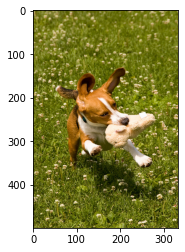

<start> a dog runs through the grass . <end>


In [22]:
import matplotlib.pyplot as plt

image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
print(sentence)

In [23]:
predictions = []
answers = []
answers_per_image = []

total_step = len(test_data_loader)
cnt = 0

with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(test_data_loader):
        images = images.to(device)
        captions = captions.to(device)

        # Forward Propagation
        features = encoder(images)
        sampled_ids_list = decoder.sample(features)

        for index in range(len(images)):
            sampled_ids = sampled_ids_list[index].cpu().numpy()

            # Answers
            answer = []
            for word_id in captions[index]: # check by a word and by an index
                word = vocab.idx2word[word_id.item()] # swap 
                answer.append(word)
                if word == '<end>':
                    break
            answers_per_image.append(answer[1:-1]) # insert correct answer excluding <sos> and <eos>

            if (cnt + 1) % 5 == 0: # 5 captions per an image
                answers.append(answers_per_image) # put 5 at a time
                answers_per_image = []

                # predicted sentences
                prediction = []
                for word_id in sampled_ids: 
                    word = vocab.idx2word[word_id] 
                    prediction.append(word)
                    if word == '<end>':
                        break
                predictions.append(prediction[1:-1]) 
            cnt += 1

        if i % log_step == 0:
            print(f"[ Testing ] Batch size: {i}/{total_step}")

[ Testing ] Batch size: 0/43
[ Testing ] Batch size: 20/43
[ Testing ] Batch size: 40/43


In [24]:
print("The number of predictions:", len(predictions))
print("The number of correct captions:", len(answers))

The number of predictions: 1091
The number of correct captions: 1091


In [25]:
index = 2
print("[ answers ]")
for answer in answers[index]:
    print(answer)

print("[ predicted captions ]")
print(predictions[index])

[ answers ]
['a', 'brown', 'and', 'white', 'dog', 'is', 'playing', 'with', 'a', 'toy', 'in', 'a', 'field', 'of', 'green', 'grass', 'and', 'clover', '.']
['a', 'brown', 'and', 'white', 'dog', 'retrieving', 'a', 'white', 'plushie', 'toy', 'in', 'a', 'field', 'of', 'clover', '.']
['a', 'distorted', 'photo', 'of', 'a', 'playing', 'dog', 'in', 'a', 'flower', 'field']
['a', 'dog', 'in', 'grass', 'carrying', 'a', 'toy', 'in', 'its', 'mouth', '.']
['the', 'little', 'brown', 'dog', 'is', 'running', 'through', 'a', 'clover', 'field', 'with', 'a', 'white', 'object', 'in', 'its', 'mouth', '.']
[ predicted captions ]
['a', 'dog', 'runs', 'through', 'the', 'grass', '.']


In [26]:
from torchtext.data.metrics import bleu_score

bleu = bleu_score(predictions, answers, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
print(f'Total BLEU Score = {bleu * 100:.2f}')

individual_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
individual_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[0, 1, 0, 0])
individual_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[0, 0, 1, 0])
individual_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[0, 0, 0, 1])

print(f'Individual BLEU1 score = {individual_bleu1_score * 100:.2f}') 
print(f'Individual BLEU2 score = {individual_bleu2_score * 100:.2f}') 
print(f'Individual BLEU3 score = {individual_bleu3_score * 100:.2f}') 
print(f'Individual BLEU4 score = {individual_bleu4_score * 100:.2f}') 

cumulative_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
cumulative_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[1/2, 1/2, 0, 0])
cumulative_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[1/3, 1/3, 1/3, 0])
cumulative_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

print(f'Cumulative BLEU1 score = {cumulative_bleu1_score * 100:.2f}') 
print(f'Cumulative BLEU2 score = {cumulative_bleu2_score * 100:.2f}') 
print(f'Cumulative BLEU3 score = {cumulative_bleu3_score * 100:.2f}') 
print(f'Cumulative BLEU4 score = {cumulative_bleu4_score * 100:.2f}')

Total BLEU Score = 15.36
Individual BLEU1 score = 57.00
Individual BLEU2 score = 23.38
Individual BLEU3 score = 9.80
Individual BLEU4 score = 4.26
Cumulative BLEU1 score = 57.00
Cumulative BLEU2 score = 36.50
Cumulative BLEU3 score = 23.55
Cumulative BLEU4 score = 15.36
